In [1]:
from voxelwise_tutorials.io import get_data_home
directory = get_data_home(dataset="shortclips")
print(directory)

/home/jlg/yuerou/voxelwise_tutorials_data/shortclips


In [2]:
# modify to use another subject
subject = "S01"

In [3]:
import os
import numpy as np
from voxelwise_tutorials.io import load_hdf5_array

file_name = os.path.join(directory, "responses", f"{subject}_responses.hdf")
Y_train = load_hdf5_array(file_name, key="Y_train")
Y_test = load_hdf5_array(file_name, key="Y_test")

print("(n_samples_train, n_voxels) =", Y_train.shape)
print("(n_repeats, n_samples_test, n_voxels) =", Y_test.shape)

(n_samples_train, n_voxels) = (3600, 84038)
(n_repeats, n_samples_test, n_voxels) = (10, 270, 84038)


In [4]:
Y_test = Y_test.mean(0)

print("(n_samples_test, n_voxels) =", Y_test.shape)

(n_samples_test, n_voxels) = (270, 84038)


In [5]:
Y_train = np.nan_to_num(Y_train)
Y_test = np.nan_to_num(Y_test)

In [6]:
feature_space = "wordnet"

file_name = os.path.join(directory, "features", f"{feature_space}.hdf")
X_train = load_hdf5_array(file_name, key="X_train")
X_test = load_hdf5_array(file_name, key="X_test")

print("(n_samples_train, n_features) =", X_train.shape)
print("(n_samples_test, n_features) =", X_test.shape)

(n_samples_train, n_features) = (3600, 1705)
(n_samples_test, n_features) = (270, 1705)


In [7]:
from sklearn.model_selection import check_cv
from voxelwise_tutorials.utils import generate_leave_one_run_out

# indice of first sample of each run
run_onsets = load_hdf5_array(file_name, key="run_onsets")
print(run_onsets)

[   0  300  600  900 1200 1500 1800 2100 2400 2700 3000 3300]


In [8]:
n_samples_train = X_train.shape[0]
cv = generate_leave_one_run_out(n_samples_train, run_onsets)
cv = check_cv(cv)  # copy the cross-validation splitter into a reusable list

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=False)

In [10]:
from voxelwise_tutorials.delayer import Delayer
delayer = Delayer(delays=[1, 2, 3, 4])

In [11]:
from himalaya.kernel_ridge import KernelRidgeCV

In [12]:
from himalaya.backend import set_backend
backend = set_backend("torch_cuda", on_error="warn")
print(backend)

<module 'himalaya.backend.numpy' from '/home/jlg/yuerou/anaconda3/envs/book5/lib/python3.9/site-packages/himalaya/backend/numpy.py'>


/home/jlg/yuerou/anaconda3/envs/book5/lib/python3.9/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to torch_cuda failed: PyTorch not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [13]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [14]:
alphas = np.logspace(1, 20, 20)

In [15]:
kernel_ridge_cv = KernelRidgeCV(
    alphas=alphas, cv=cv,
    solver_params=dict(n_targets_batch=500, n_alphas_batch=5,
                       n_targets_batch_refit=100))

In [16]:
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(
    scaler,
    delayer,
    kernel_ridge_cv,
)

In [17]:
from sklearn import set_config
set_config(display='diagram')  # requires scikit-learn 0.23
pipeline

Pipeline(steps=[('standardscaler', StandardScaler(with_std=False)),
                ('delayer', Delayer(delays=[1, 2, 3, 4])),
                ('kernelridgecv',
                 KernelRidgeCV(alphas=array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15, 1.e+16,
       1.e+17, 1.e+18, 1.e+19, 1.e+20]),
                               cv=_CVIterableWrapper(cv=[(array([ 300,  301, ..., 3598, 3599]), a..., (array([   0,    1, ..., 3598, 3599]), array([1200, 1201, ..., 1498, 1499])), (array([   0,    1, ..., 3598, 3599]), array([2700, 2701, ..., 2998, 2999])), (array([   0,    1, ..., 3598, 3599]), array([2400, 2401, ..., 269... 2101, ..., 2398, 2399])), (array([   0,    1, ..., 3598, 3599]), array([300, 301, ..., 598, 599]))]),
                               solver_params={'n_alphas_batch': 5,
                                              'n_targets_batch': 500,
                                              'n_targets_batch_refit': 100}))])

In [18]:
_ = pipeline.fit(X_train, Y_train)

In [19]:
scores = pipeline.score(X_test, Y_test)
print("(n_voxels,) =", scores.shape)

(n_voxels,) = (84038,)


In [20]:
scores = backend.to_numpy(scores)

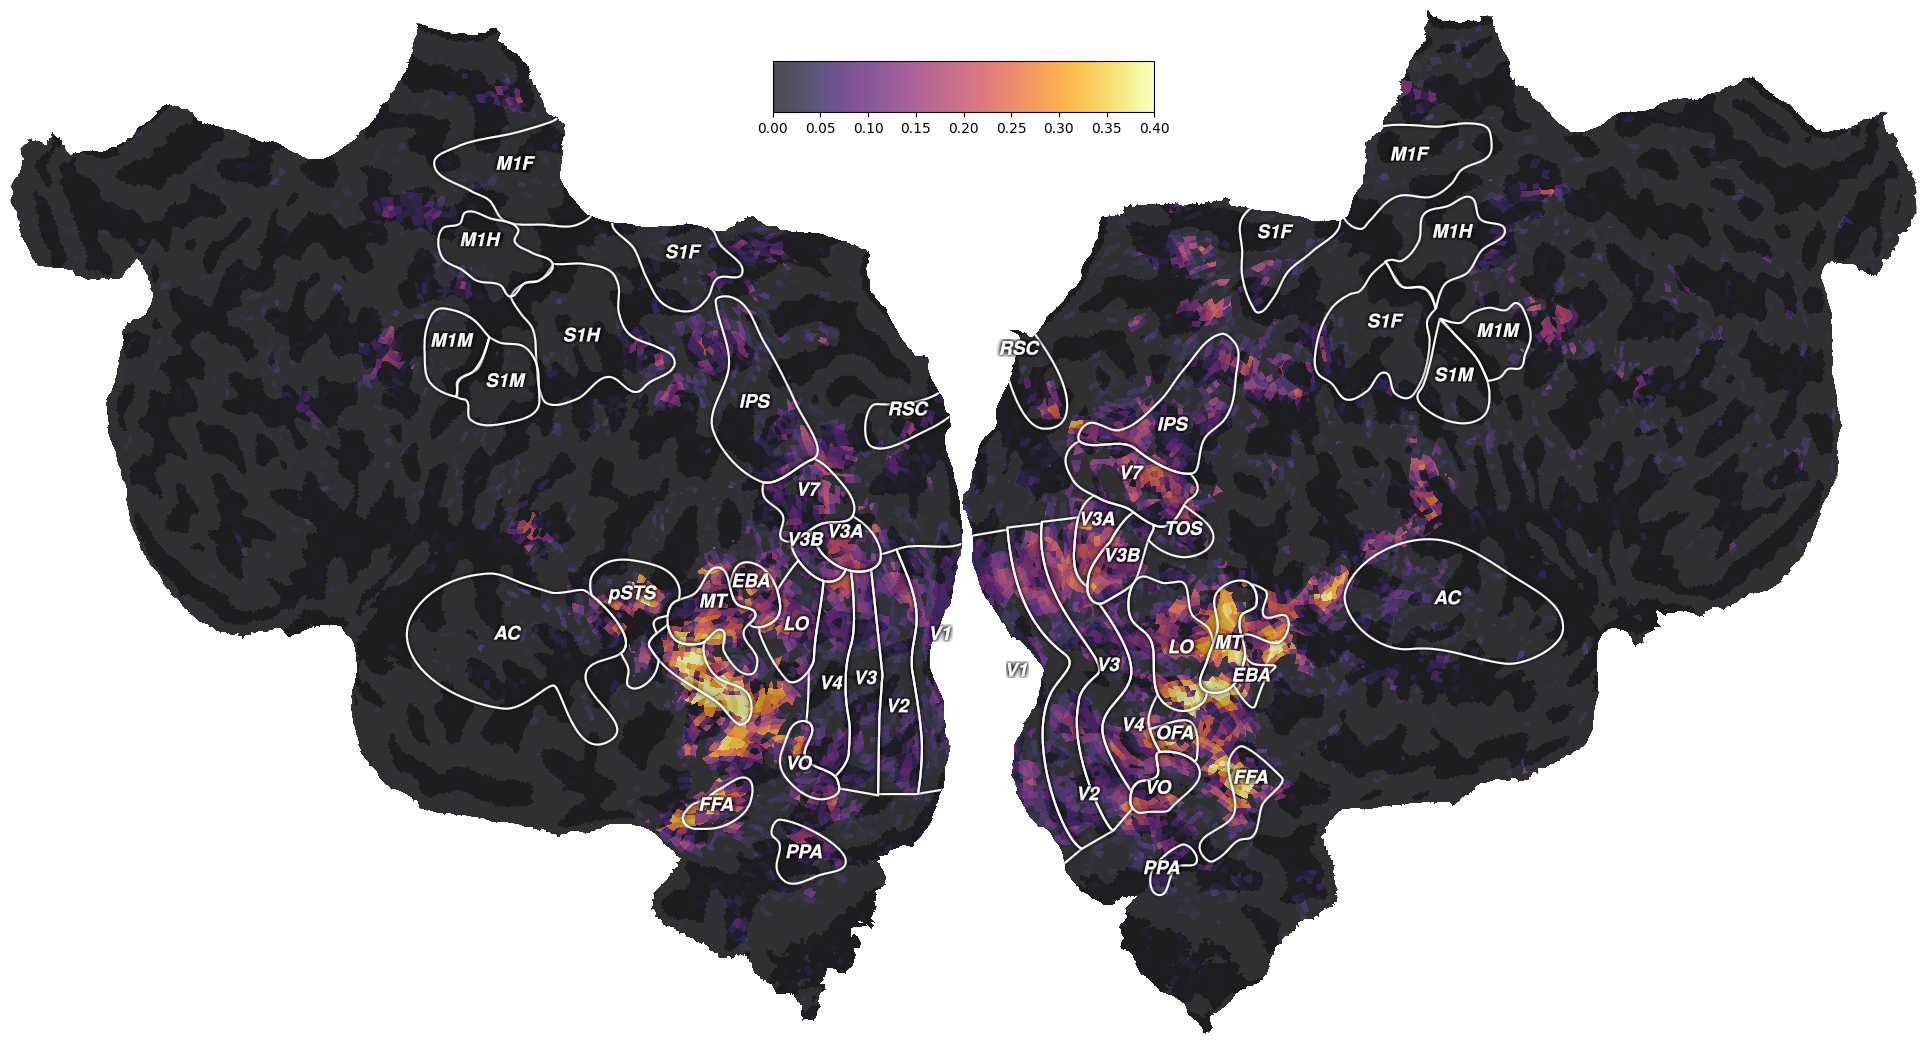

In [21]:
import matplotlib.pyplot as plt
from voxelwise_tutorials.viz import plot_flatmap_from_mapper

mapper_file = os.path.join(directory, "mappers", f"{subject}_mappers.hdf")
ax = plot_flatmap_from_mapper(scores, mapper_file, vmin=0, vmax=0.4)
plt.show()

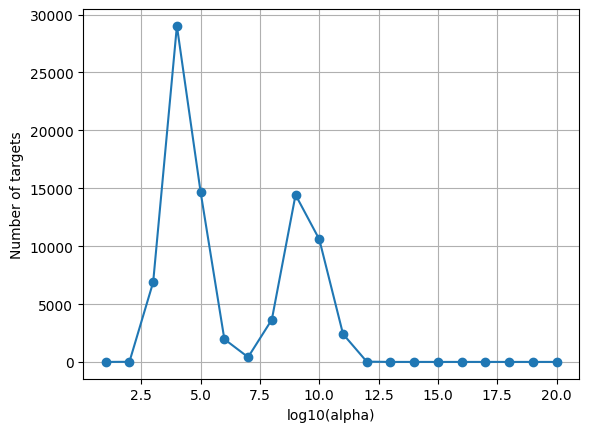

In [22]:
from himalaya.viz import plot_alphas_diagnostic
best_alphas = backend.to_numpy(pipeline[-1].best_alphas_)
plot_alphas_diagnostic(best_alphas=best_alphas, alphas=alphas)
plt.show()

In [23]:
primal_coef = pipeline[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)
print("(n_delays * n_features, n_voxels) =", primal_coef.shape)

(n_delays * n_features, n_voxels) = (6820, 84038)


In [24]:
primal_coef /= np.linalg.norm(primal_coef, axis=0)[None]
primal_coef *= np.sqrt(np.maximum(0, scores))[None]

In [25]:
# split the ridge coefficients per delays
delayer = pipeline.named_steps['delayer']
primal_coef_per_delay = delayer.reshape_by_delays(primal_coef, axis=0)
print("(n_delays, n_features, n_voxels) =", primal_coef_per_delay.shape)
del primal_coef

# average over delays
average_coef = np.mean(primal_coef_per_delay, axis=0)
print("(n_features, n_voxels) =", average_coef.shape)
del primal_coef_per_delay

(n_delays, n_features, n_voxels) = (4, 1705, 84038)


(n_features, n_voxels) = (1705, 84038)


In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(average_coef.T)
components = pca.components_
print("(n_components, n_features) =", components.shape)

(n_components, n_features) = (4, 1705)


In [27]:
print("PCA explained variance =", pca.explained_variance_ratio_)

PCA explained variance = [0.35209077 0.08103414 0.05655064 0.03764926]


In [28]:
from voxelwise_tutorials.wordnet import load_wordnet
from voxelwise_tutorials.wordnet import correct_coefficients
_, wordnet_categories = load_wordnet(directory=directory)
components = correct_coefficients(components.T, wordnet_categories).T
components -= components.mean(axis=1)[:, None]
components /= components.std(axis=1)[:, None]

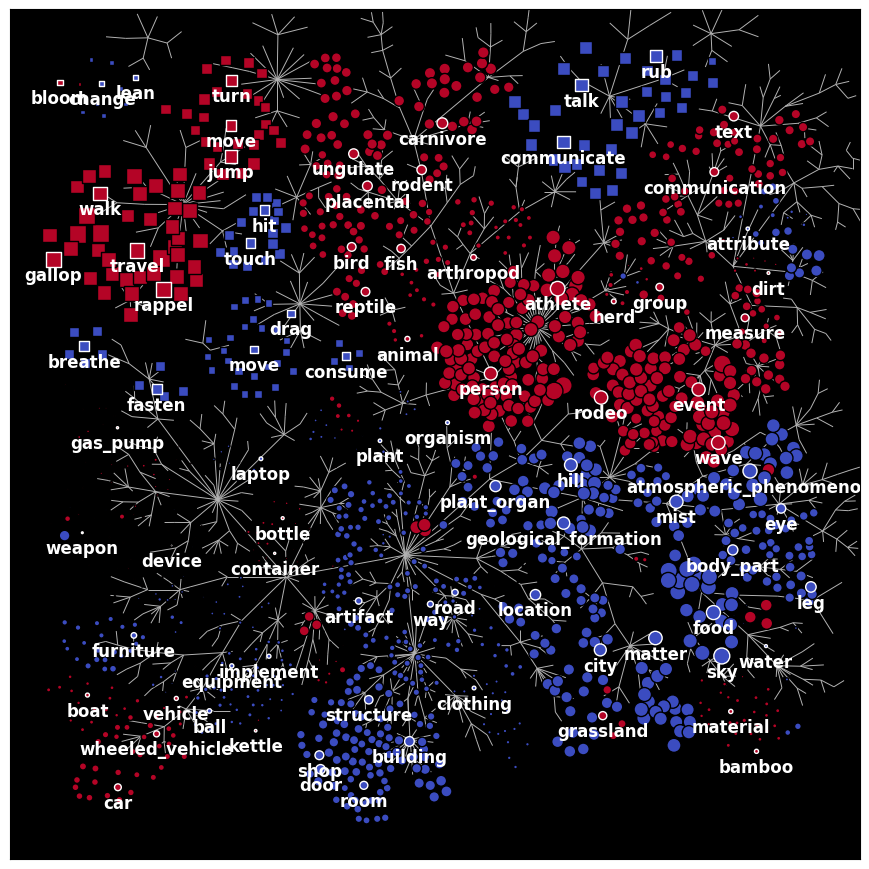

In [29]:
from voxelwise_tutorials.wordnet import plot_wordnet_graph
from voxelwise_tutorials.wordnet import apply_cmap

first_component = components[0]
node_sizes = np.abs(first_component)
node_colors = apply_cmap(first_component, vmin=-2, vmax=2, cmap='coolwarm',
                         n_colors=2)

plot_wordnet_graph(node_colors=node_colors, node_sizes=node_sizes)
plt.show()

(n_components, n_voxels) = (4, 84038)


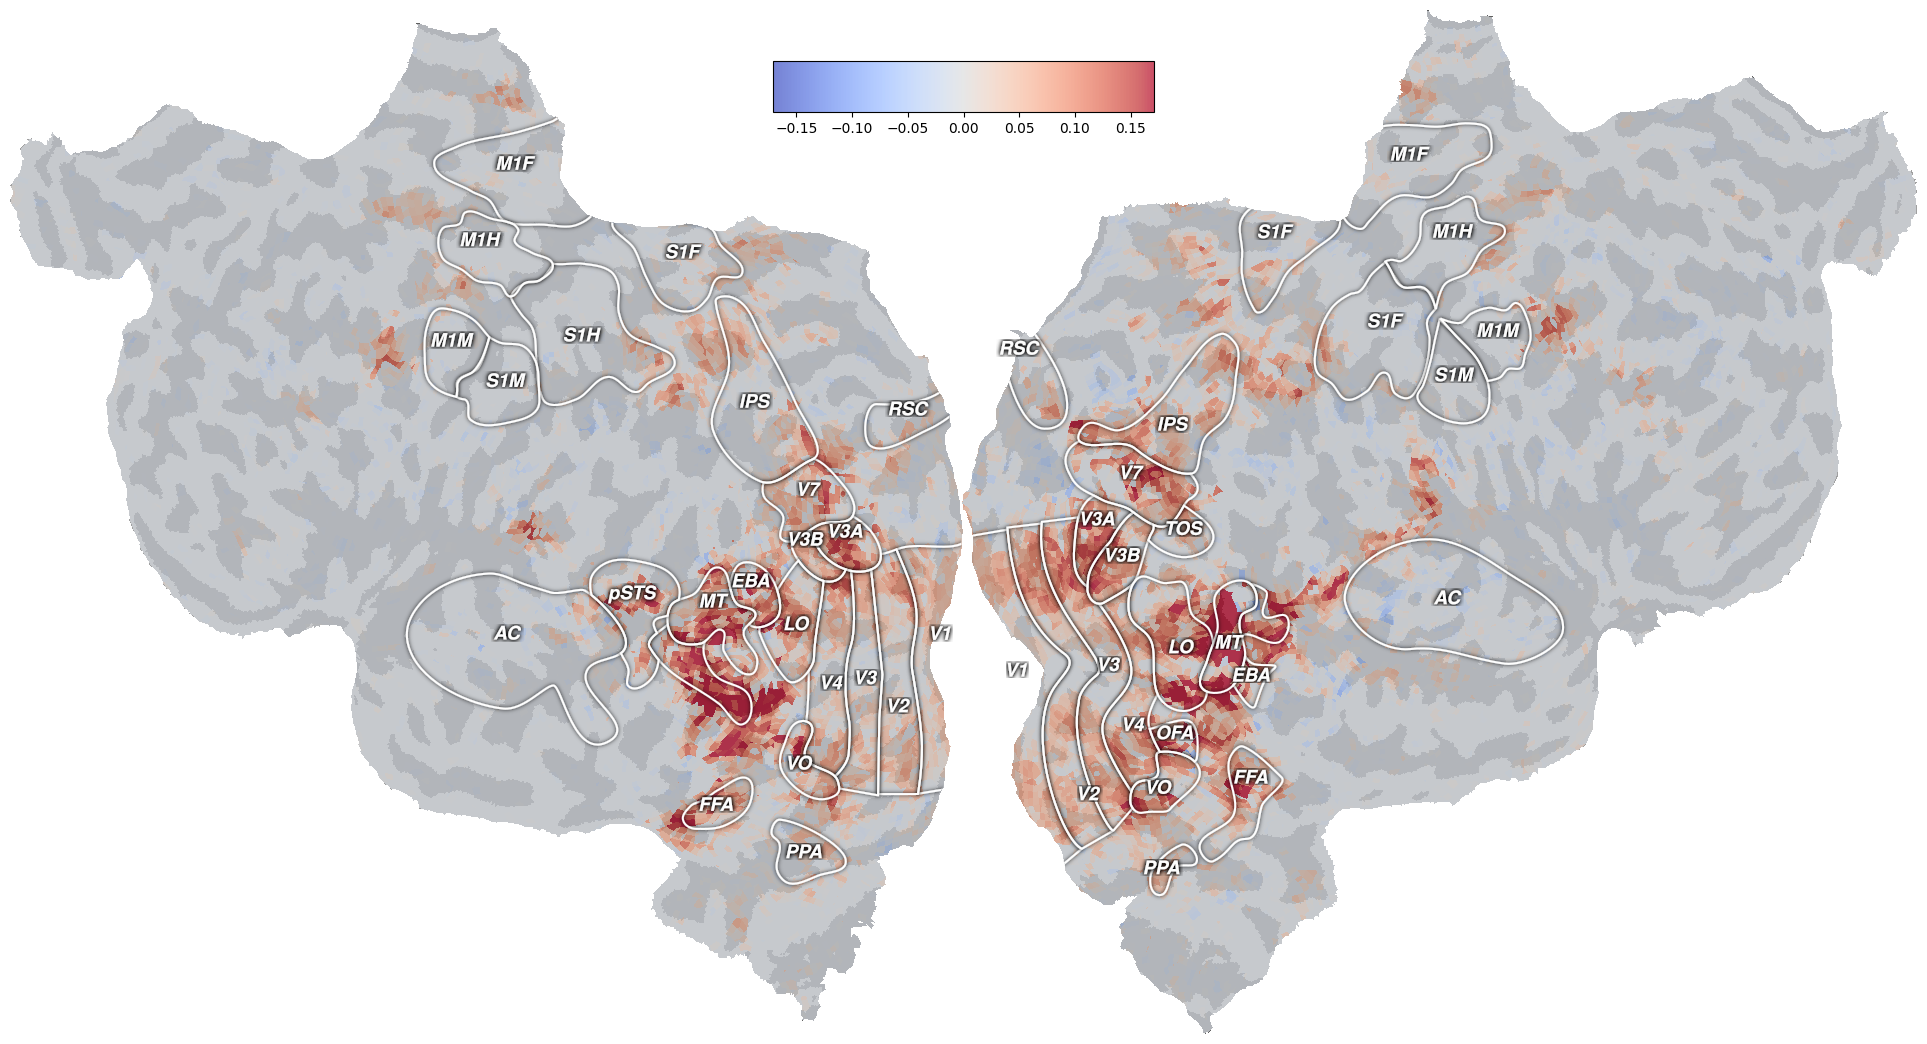

In [30]:
# transform with the fitted PCA
average_coef_transformed = pca.transform(average_coef.T).T
print("(n_components, n_voxels) =", average_coef_transformed.shape)
del average_coef

# We make sure vmin = -vmax, so that the colormap is centered on 0.
vmax = np.percentile(np.abs(average_coef_transformed), 99.9)

# plot the primal weights projected on the first principal component.
ax = plot_flatmap_from_mapper(average_coef_transformed[0], mapper_file,
                              vmin=-vmax, vmax=vmax, cmap='coolwarm')
plt.show()

(n_nodes, n_channels) = (1705, 3)


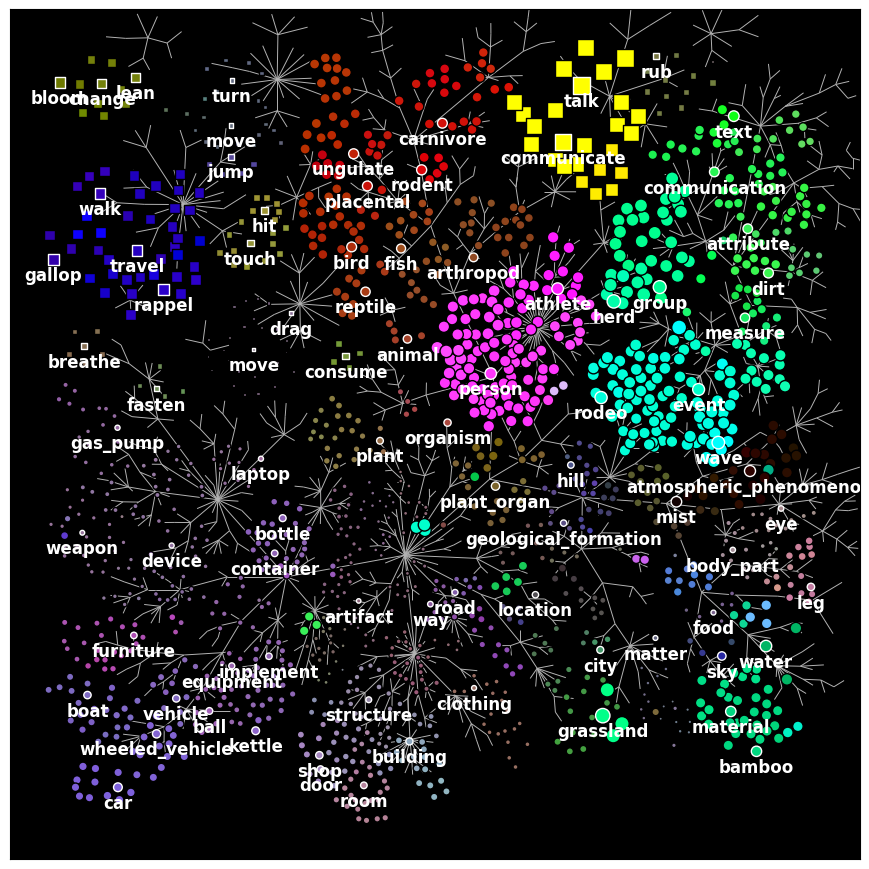

In [31]:
from voxelwise_tutorials.wordnet import scale_to_rgb_cube

next_three_components = components[1:4].T
node_sizes = np.linalg.norm(next_three_components, axis=1)
node_colors = scale_to_rgb_cube(next_three_components)
print("(n_nodes, n_channels) =", node_colors.shape)

plot_wordnet_graph(node_colors=node_colors, node_sizes=node_sizes)
plt.show()

(n_channels, n_voxels) = (3, 84038)


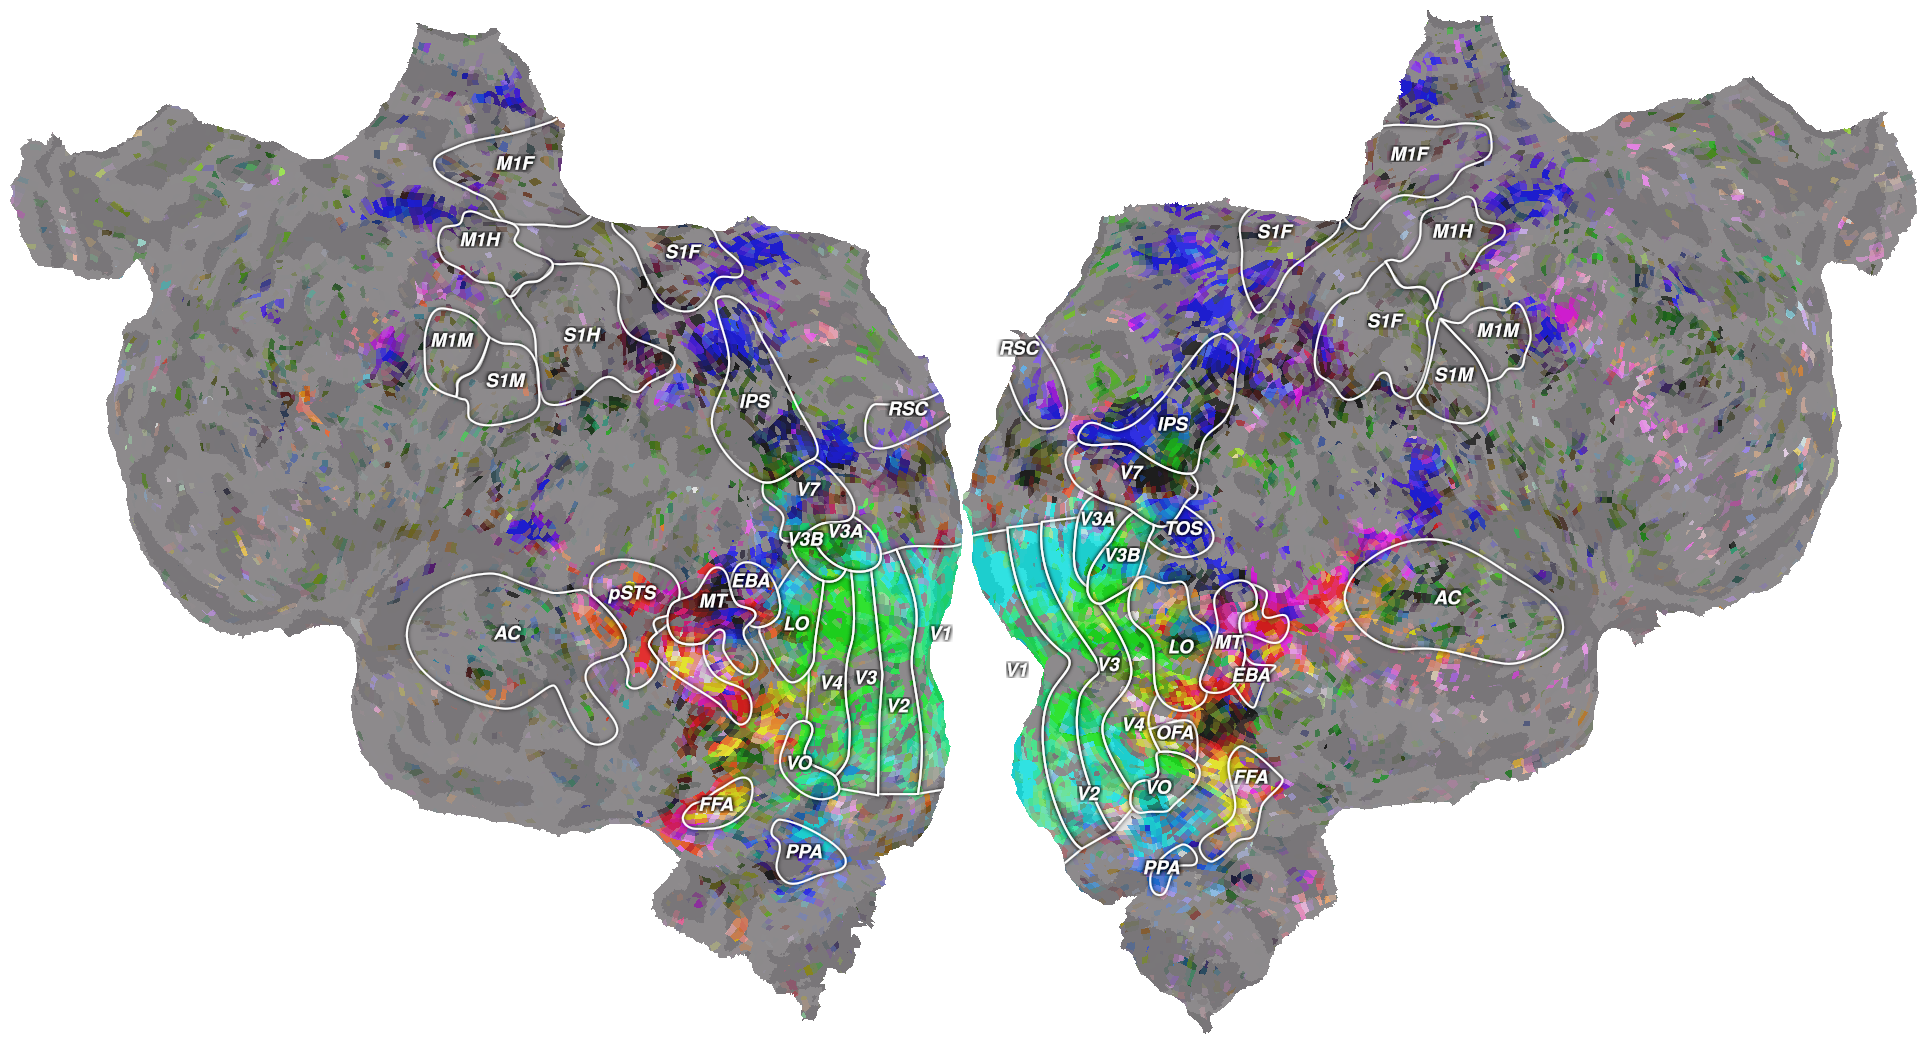

In [32]:
from voxelwise_tutorials.viz import plot_3d_flatmap_from_mapper

voxel_colors = scale_to_rgb_cube(average_coef_transformed[1:4].T, clip=3).T
print("(n_channels, n_voxels) =", voxel_colors.shape)

ax = plot_3d_flatmap_from_mapper(voxel_colors[0], voxel_colors[1],
                                 voxel_colors[2], mapper_file=mapper_file,
                                 vmin=0, vmax=1, vmin2=0, vmax2=1, vmin3=0,
                                 vmax3=1)
plt.show()